In [9]:
pip install healpy numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [10]:
import healpy as hp

# Load SMICA Q and U maps (field=1 and 2)
map_path = "/kaggle/input/smica-planck/COM_CMB_IQU-smica_2048_R3.00_full.fits"
Q_map, U_map = hp.read_map(map_path, field=(1, 2), verbose=False)

/tmp/ipykernel_35/4116372.py:5: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  Q_map, U_map = hp.read_map(map_path, field=(1, 2), verbose=False)


In [11]:
import numpy as np

# Create a dummy T map (same shape as Q/U)
T_map = np.zeros_like(Q_map)

# Now pass all three: T, Q, U
alm_TEB = hp.map2alm([T_map, Q_map, U_map], pol=True, lmax=3000)

# Convert back to maps (T, E, B)
T_E_B_maps = hp.alm2map(alm_TEB, nside=2048, pol=True)
E_map = T_E_B_maps[1]
B_map = T_E_B_maps[2]


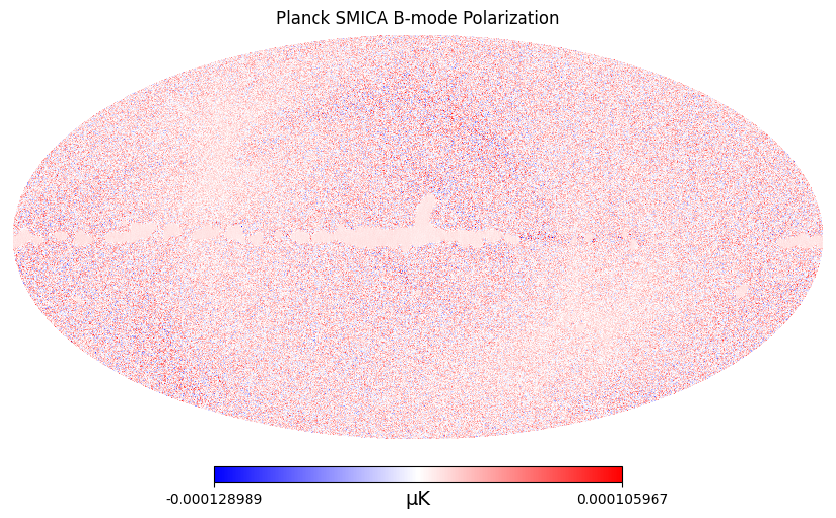

In [13]:
import matplotlib.pyplot as plt

hp.mollview(B_map, title="Planck SMICA B-mode Polarization", unit="μK", cmap="bwr")
plt.show()

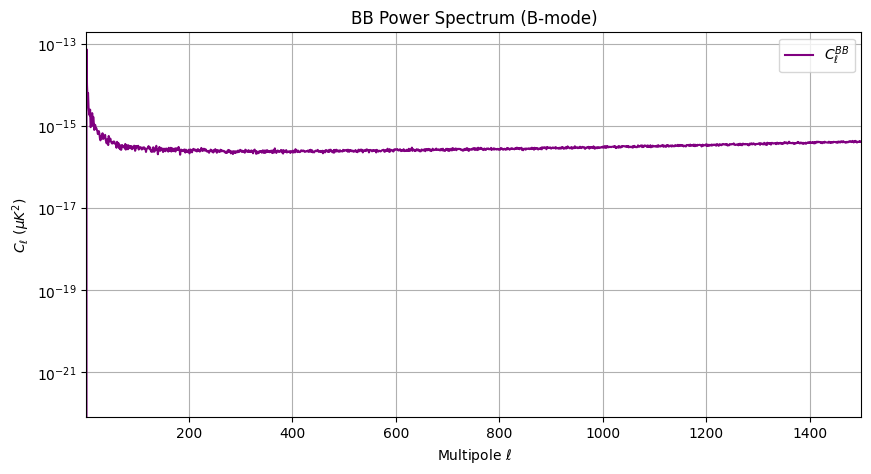

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

# Dummy T map
T_map = np.zeros_like(Q_map)

# Compute the power spectrum
cl_TEB = hp.anafast([T_map, Q_map, U_map], pol=True)

# cl_TEB[2] is C_ell^BB
ell = np.arange(len(cl_TEB[2]))

plt.figure(figsize=(10, 5))
plt.plot(ell, cl_TEB[2], label=r"$C_\ell^{BB}$", color="purple")
plt.yscale("log")
plt.xlabel("Multipole $\ell$")
plt.ylabel(r"$C_\ell\ (\mu K^2)$")
plt.title("BB Power Spectrum (B-mode)")
plt.legend()
plt.grid(True)
plt.xlim([2, 1500])
plt.show()


In [16]:
def extract_patch(map_data, lon, lat, size=64, reso=3):
    patch = hp.gnomview(map_data, rot=(lon, lat), xsize=size, ysize=size, reso=reso, return_projected_map=True, no_plot=True)
    return patch

coords = [(l, b) for l in range(0, 360, 20) for b in range(-60, 70, 20)]
bmode_patches = [extract_patch(B_map, l, b) for l, b in coords if extract_patch(B_map, l, b) is not None]

In [17]:
from sklearn.preprocessing import MinMaxScaler

X = np.array([p.flatten() for p in bmode_patches])
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(4096, 256), nn.ReLU(), nn.Linear(256, 64))
        self.decoder = nn.Sequential(nn.Linear(64, 256), nn.ReLU(), nn.Linear(256, 4096), nn.Sigmoid())

    def forward(self, x): return self.decoder(self.encoder(x))

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_tensor), batch_size=16, shuffle=True)

model = AE()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Train
for epoch in range(20):
    for batch in train_loader:
        x = batch[0]
        loss = loss_fn(model(x), x)
        opt.zero_grad(); loss.backward(); opt.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.0314
Epoch 2, Loss: 0.0347
Epoch 3, Loss: 0.0302
Epoch 4, Loss: 0.0331
Epoch 5, Loss: 0.0355
Epoch 6, Loss: 0.0305
Epoch 7, Loss: 0.0304
Epoch 8, Loss: 0.0318
Epoch 9, Loss: 0.0278
Epoch 10, Loss: 0.0323
Epoch 11, Loss: 0.0395
Epoch 12, Loss: 0.0336
Epoch 13, Loss: 0.0329
Epoch 14, Loss: 0.0277
Epoch 15, Loss: 0.0277
Epoch 16, Loss: 0.0286
Epoch 17, Loss: 0.0302
Epoch 18, Loss: 0.0275
Epoch 19, Loss: 0.0312
Epoch 20, Loss: 0.0333


In [19]:
model.eval()
with torch.no_grad():
    recon = model(X_tensor)
    mse_loss = ((X_tensor - recon) ** 2).mean(dim=1)

threshold = torch.quantile(mse_loss, 0.9)
anomaly_indices = torch.where(mse_loss > threshold)[0]

In [20]:
import os
import matplotlib.pyplot as plt

output_dir = "bmode_anomalies"
os.makedirs(output_dir, exist_ok=True)

for i, idx in enumerate(anomaly_indices):
    patch = bmode_patches[idx]
    plt.imsave(f"{output_dir}/patch_{i+1}.png", patch, cmap="coolwarm")
